In [1]:
import networkx as nx
import ndlib.models.epidemics.SIRModel as sir
from ndlib.utils import multi_runs
import ndlib.models.ModelConfig as mc
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn import metrics
np.random.seed(1)

## 1) Introduction : SIR model Example

In [2]:
# Network Definition
nbr_nodes = 25
g = nx.erdos_renyi_graph(nbr_nodes, 0.1)

# Model Selection
model = sir.SIRModel(g)

In [3]:
import ndlib.models.ModelConfig as mc

# Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.01)
config.add_model_parameter('gamma', 0.01)
#config.add_model_parameter("percentage_infected", 0.05)
model.set_initial_status(config)

/home/matthieu/.local/lib/python3.6/site-packages/ndlib/models/DiffusionModel.py:114: UserWarning: Initial infection missing: a random sample of 5% of graph nodes will be set as infected
  warnings.warn('Initial infection missing: a random sample of 5% of graph nodes will be set as infected')


In [4]:
# Simulation
N=1
infection_sets = [(4,5) for i in range(N) ]
trends = multi_runs(model, execution_number=N, iteration_number=100, infection_sets=infection_sets, nprocesses=4)

In [5]:
from bokeh.io import output_notebook, show
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
import matplotlib.pyplot as plt

viz = DiffusionTrend(model, trends)
viz.plot("diffusion.pdf", percentile=90)
plt.show()

In [6]:
infected_nodes = trends[0]['trends']['node_count'][1][99]
immune_nodes = trends[0]['trends']['node_count'][2][99]
total=immune_nodes + infected_nodes
total

7

## 2) Cost and Submodular function definition

In [7]:
def cluster_linear_cost(g, S):
    '''
    Linear Cluster cost : compute the cost of selecting the nodes S
    The cost is linear with a neighbors/clustering measure
    '''
    #res = nx.clustering(g, S)
    cost = 0
    for i in S:
        #cost += res[i]*100
        cost += len(g[i])*100
    return(max(cost,1))

#Example
cluster_linear_cost(g, [4,1])

#Other ideas for the cost
#According to people : 100 $ for 10.000 followers. We could use 
#a cost function linear to the number of neigbors.

200

In [31]:
def expected_infected_nodes(S, model, T, N=20):
    '''
    S : Initial infected nodes [list] (variable)
    model : infection model [NDlib model] (parameter)
    T : number of iteration [int] (parameter)
    N : Number of simulation for Monte Carlo [int] (parameter)'''
    if len(S)==0:
        return(0)
    infection_sets = [S for i in range(N)]
    model.reset()
    trends = multi_runs(model, execution_number=N, iteration_number=T, infection_sets=infection_sets)
    res = 0
    for i in trends:
        res += i['trends']['node_count'][1][T-1]
        res += i['trends']['node_count'][2][T-1]
    res = float(res)/float(N)
    return(res)

In [15]:
#Example. Note : this will be the submodular function to maximize
expected_infected_nodes([4,1], model, T=100, N=10)

10


20

## 3) Greedy algorithm (for submodular functions)

In [68]:
N0 = 50
T0 = 100
B = 1000
def f_sub(x):
    return expected_infected_nodes(x, model, T0, N0)

def cost(x):
    res = cluster_linear_cost(g, x)
    return(res)

def g_1(f, G, u, c, r):
    return((f(G+[u])-f(G))/(c([u]))**r )

def greedy_submodular(f, V, c):
    r=1
    G = []
    U = V.copy()
    cost = 0
    while len(U)!=0 and B-cost>100:
        L = [g_1(f, G, u, c, r) for u in U]
        k = U[np.array(L).argmax()]
        if cost + c([k]) <= B: # and f(G + [k])- f(G) >= 0: 
            G += [k]
            cost += c([k])
        U.remove(k)
        print(len(G))
    L = [f([i]) for i in V if c([i])<B]
    v = np.array(L).argmax()
    if f(G)>f([V[v]]):
        return(G)
    else:
        return(V[v])

In [22]:
# Example
S = greedy_submodular(f_sub, list(range(nbr_nodes)), cost)

1
2
3
4
5
6
7
7
8


In [36]:
print(S,f_sub(S))

[1, 5, 9, 4, 10, 11, 12, 2] 14.94


['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']


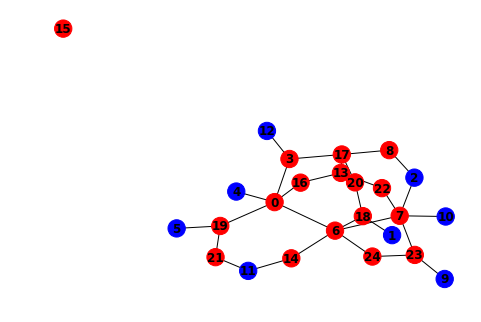

[1, 5, 9, 4, 10, 11, 12, 2]

In [34]:
#g2 = g.copy()
#g2.remove_nodes_from(nx.isolates(g)) 
color_map = ['red' for node in g.nodes]
print(color_map)
for i in S:
    color_map[i] = 'blue'
nx.draw(g, with_labels=True, node_color = color_map, font_weight='bold')
plt.show()
S

## 4) Others submodular function
The problem with 'expected_infected_nodes' is its computational cost. Indeed, the function is a simulation, and it can be very long to compute the expected number of infected nodes for very big networks (it's slow even for a network of size 50)

### a) Coverage and Diversity submodular functions
One first idea would be the following :  <b> use some submodular document summarization tricks </b> for our problem. Document summarization with submodular functions optimization is a well studied problem. A very popular formulation ("A class of submodular function for document summarization" by Hui Lin and Jeff Bilmes) is to decompose the submodular function to optimize into a <b>coverage function </b> and a <b> diversity function</b>.

In [26]:
# Diversity function

# 1) Clustering for div_R
# To have the desired diversity function, we need a clustering of nodes

# Get your mentioned graph
n_clusters = 3

# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(g)
# Cluster
sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

# Compare ground-truth and clustering-results
print('spectral clustering')
print(sc.labels_)
cluster = {k:[] for k in range(n_clusters)}
for i in range(len(sc.labels_)):
    cluster[sc.labels_[i]].append(i)

spectral clustering
[0 0 1 0 0 2 1 1 0 1 1 2 0 0 2 0 0 0 0 2 0 2 0 1 1]


/home/matthieu/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [44]:
#2) div_R definition
def div_R(S, V, cluster, g, alpha=0.8):
    degree_cent = nx.degree_centrality(g)
    K = len(cluster)
    res = 0
    for k in range(K):
        S_inter_Pk = list(set(S) & set(cluster[k]))
        res1 = 0
        for j in S_inter_Pk:
            res1 += degree_cent[j]
        res += np.sqrt(res1)
    return(res)

In [27]:
# 3) Coverage function (how much some nodes covers the network)
def cov_L(S, V, g, alpha=0.8):
    res = 0
    degree_cent = nx.degree_centrality(g)
    for x in S:
        res += degree_cent[x]
    return(res)

# 4) submodular function = cov + div
def covdiv_F(S, V, cluster, g, lambda1=0.5):
    if len(S)==0:
        return(0)
    return(cov_L(S, V, g) + lambda1*div_R(S, V, cluster, g))

In [28]:
# Easy functions to use for greedy algorithm
def f_sub_2(S):
    return covdiv_F(S, g.nodes, cluster, g, lambda1=0.5)

In [29]:
# Test for a random model
S = greedy_submodular(f_sub_2, list(range(nbr_nodes)), cost)
print(S)
print(cluster)

1
2
3
4
5
6
7
8
[1, 5, 9, 4, 10, 11, 12, 2]
{0: [0, 1, 3, 4, 8, 12, 13, 15, 16, 17, 18, 20, 22], 1: [2, 6, 7, 9, 10, 23, 24], 2: [5, 11, 14, 19, 21]}


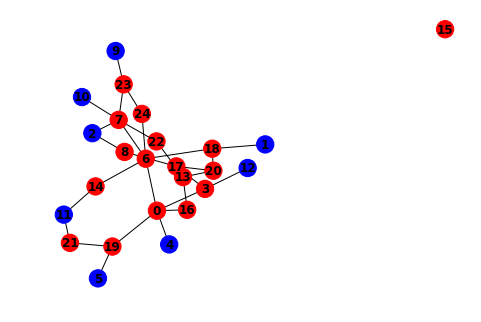

21.0

In [32]:
#g2 = g.copy()
#g2.remove_nodes_from(nx.isolates(g)) 
color_map = ['red' for node in g.nodes]
if type(S)==int:
    S =[S]
for i in S:
    color_map[i] = 'blue'
nx.draw(g, with_labels=True, node_color = color_map, font_weight='bold')
plt.show()
f_sub(S)

It seems the result is the same, but much quicker ! We can use this function for huge networks.

## 5) Experiments (real networks)

### a) Data loading

In [65]:
file = 'data/facebook_combined.txt'
gf = nx.read_edgelist(file,create_using=nx.Graph())
gf = nx.convert_node_labels_to_integers(gf)
print(len(gf.nodes))

model = sir.SIRModel(gf)
# Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.01)
config.add_model_parameter('gamma', 0.01)
#config.add_model_parameter("percentage_infected", 0.05)
model.set_initial_status(config)

4039


/home/matthieu/.local/lib/python3.6/site-packages/ndlib/models/DiffusionModel.py:114: UserWarning: Initial infection missing: a random sample of 5% of graph nodes will be set as infected
  warnings.warn('Initial infection missing: a random sample of 5% of graph nodes will be set as infected')


### b) Optimization
#### Cluster creation

In [66]:
n_clusters = 20

# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(gf)
# Cluster
sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

# Compare ground-truth and clustering-results
print('spectral clustering')
print(sc.labels_)
cluster = {k:[] for k in range(n_clusters)}
for i in range(len(sc.labels_)):
    cluster[sc.labels_[i]].append(i)

spectral clustering
[14  4  8 ...  2  2  2]


#### Optimization with f_sub2 (cov_div submodular function)

In [69]:
B = 3000
T0 = 10000 
g=gf
S = greedy_submodular(f_sub_2, list(gf.nodes), cost)
print(S)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
[11, 397, 1526, 1837, 2406, 3059, 3987, 47, 551, 1793, 3620, 3821, 3950, 2367, 220, 404, 12, 1603]


In [71]:
print(S)
f_sub(S)

[11, 397, 1526, 1837, 2406, 3059, 3987, 47, 551, 1793, 3620, 3821, 3950, 2367, 220, 404, 12, 1603]


3888.0